In [1]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1. Load Data

In [2]:
df_movies = pd.read_csv('./ml-latest20M/movies copy.csv')

df_ratings = pd.read_csv('./ml-latest20M/ratings copy.csv')

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
movie_id    58098 non-null int64
title       58098 non-null object
genres      58098 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
user_id      1048575 non-null int64
movie_id     1048575 non-null int64
rating       1048575 non-null float64
timestamp    1048575 non-null int64
dtypes: float64(1), int64(3)
memory usage: 32.0 MB


In [5]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [7]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.movie_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 10532 unique users and 22156 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

get the counts of each rating from ratings data

In [8]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,19099
1.0,33017
1.5,16660
2.0,70427
2.5,51076
3.0,209822
3.5,128663
4.0,278222
4.5,89672


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [9]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,232298417
0.5,19099
1.0,33017
1.5,16660
2.0,70427
2.5,51076
3.0,209822
3.5,128663
4.0,278222
4.5,89672


The count for zero rating score is too big to compare with others. Take log transform for count values and plot them to compare

In [10]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,232298417,19.263533
0.5,19099,9.857391
1.0,33017,10.404778
1.5,16660,9.720766
2.0,70427,11.162332
2.5,51076,10.841070
3.0,209822,12.254015
3.5,128663,11.764952
4.0,278222,12.536175
4.5,89672,11.403914


Text(0, 0.5, 'number of ratings')

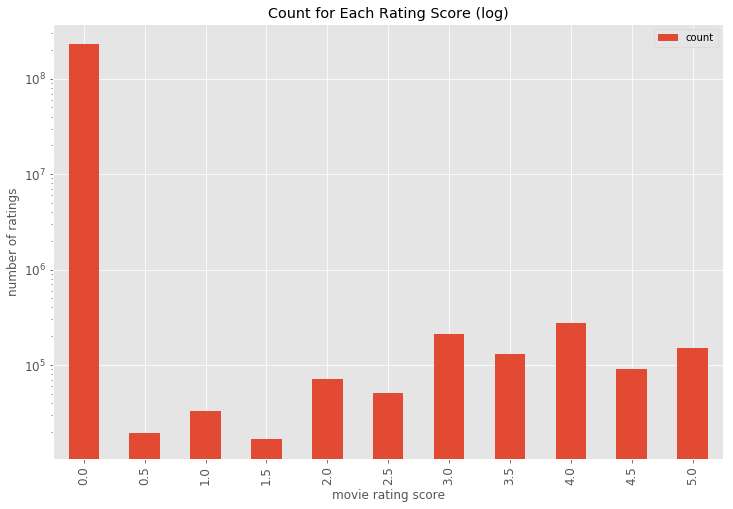

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (log)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [12]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [13]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movie_id').size(), columns=['count'])
df_movies_cnt.head()

,count
movie_id,
1,2573
2,1021
3,629
4,129
5,592


Text(0, 0.5, '# of Ratings')

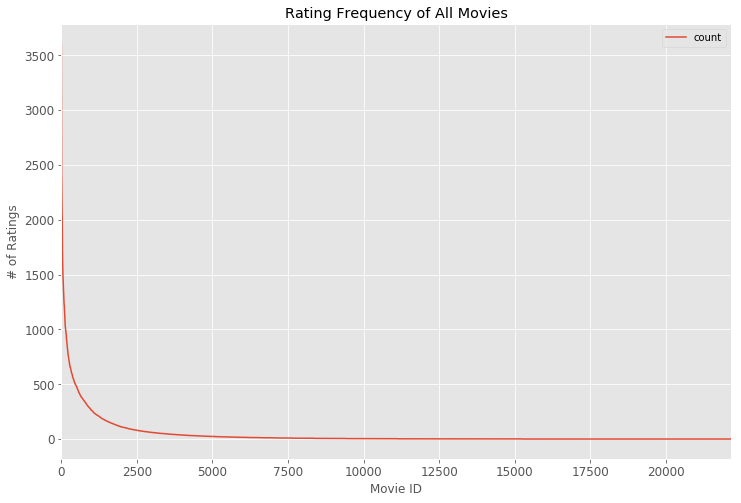

In [14]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("Movie ID")
ax.set_ylabel("# of Ratings")

    *only a small fraction of the items are rated frequently
    *These are referred to as popular items
    *majority of items are rarely rated
    *This results in a highly skewed distribution

Text(0, 0.5, 'number of ratings (log scale)')

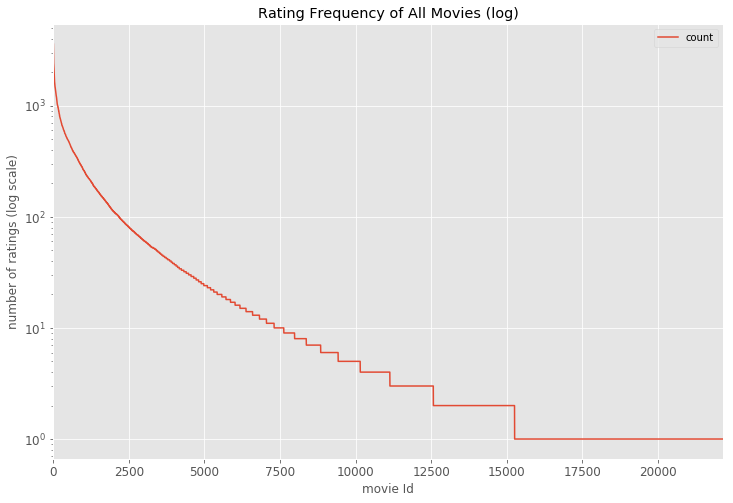

In [15]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (log)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [16]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    3606.0
0.95     234.0
0.90      96.0
0.85      52.0
0.80      31.0
0.75      20.0
0.70      13.0
0.65       9.0
Name: count, dtype: float64

In [17]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movie_id.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (1048575, 4)
shape of ratings data after dropping unpopular movies:  (915383, 4)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
1,16
2,15
3,6
4,689
5,68


Text(0, 0.5, '# of ratings')

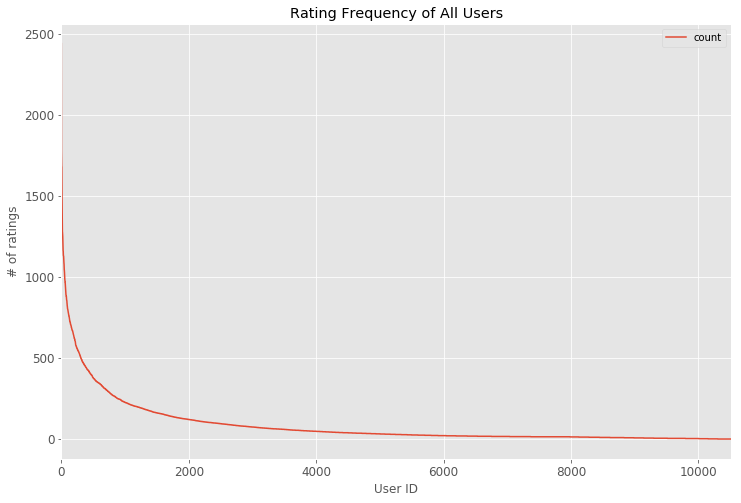

In [19]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User ID")
ax.set_ylabel("# of ratings")

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    2441.0
0.95     368.0
0.90     219.0
0.85     156.0
0.80     115.0
0.75      90.0
0.70      70.0
0.65      55.0
0.60      44.0
0.55      36.0
Name: count, dtype: float64

After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

    *Distribution of ratings by users =very similiar = distribution of ratings among movies
    *long-tail property
    *small fraction of users are engaged in rating movies
    *most of them do not rate at all
    *so we further reduce users

In [21]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (1048575, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (793904, 4)


In [22]:
df_ratings_drop_users.head(10)

,user_id,movie_id,rating,timestamp
42,4,1,4.0,1113765937
43,4,2,4.0,1113767306
44,4,5,2.0,1123990453
45,4,6,4.5,1113767242
46,4,10,4.0,1113765995
47,4,11,3.5,1113767280
48,4,16,4.0,1113765691
49,4,19,2.0,1113767324
50,4,20,2.5,1145937918
51,4,23,3.0,1115782385


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data

    *for knn, the data needs to be in (movie, user) array
    *each row is a movie and each column is a different user
    *pivot the dataframe to wide format with movies as rows and users as columns
    *then fill missing observations with 0s
    *perform linear algebra to calculate distance between vectors
    *then transform the values of the DF into a SciPy sparse matrix 

In [23]:
# Pivot then create movie-user matrix
movie_user_matrix = df_ratings_drop_users.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)
# Create mapper from movie title to index
movie_to_index = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movie_id').loc[movie_user_matrix.index].title))
}
# Transfor matrix to a SciPy sparse
movie_user_matrix_sparse = csr_matrix(movie_user_matrix.values)

In [24]:
import pickle
pickle.dump(movie_to_index, open('mapper20.pkl','wb'))
pickle.dump(movie_user_matrix_sparse, open('sparse20.pkl', 'wb'))

In [25]:
movie_user_matrix.head()

user_id,4,5,10,14,15,18,19,26,31,34,...,10516,10517,10518,10519,10524,10526,10527,10529,10531,10532
movie_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,5.0,4.5,4.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,5.0,0.0
2,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Fitting the Model
    *Initialize the NearestNeighbors class as model_knn and fit the sparse matrix to the instance. 
    *By specifying the metric = cosine, euclidean and hamming.

In [27]:
import pickle
pickle.dump(model_knn, open('moviesKnn20.pkl','wb'))

## 4. Use this trained model to make movie recommendations to myself


In [28]:
def fuzzy_matching(mapper, fav_movie, verbose=True):

    match_tuple = []
    
    # get match
    for title, index in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, index, ratio))
            
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):

    # fit
    model_knn.fit(data)
    
    # get input movie index
    print('You have input movie:', fav_movie)
    index = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[index], n_neighbors=n_recommendations+1)
    
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} with distance {2:.4f}'.format(i+1, reverse_mapper[idx], dist))

In [26]:
# Model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# Fit
model_knn.fit(movie_user_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [29]:
fav = 'Toy Story'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=fav,
    mapper=movie_to_index,
    n_recommendations=20)

You have input movie: Aladdin
Found possible matches in our database: ['Aladdin (1992)']

Recommendation system start to make inference
......

Recommendations for Aladdin:
1: Braveheart (1995) with distance 0.4735
2: Silence of the Lambs, The (1991) with distance 0.4722
3: Terminator 2: Judgment Day (1991) with distance 0.4693
4: Pretty Woman (1990) with distance 0.4687
5: Dances with Wolves (1990) with distance 0.4625
6: Ace Ventura: Pet Detective (1994) with distance 0.4591
7: Fugitive, The (1993) with distance 0.4423
8: Batman Forever (1995) with distance 0.4403
9: True Lies (1994) with distance 0.4393
10: Home Alone (1990) with distance 0.4364
11: Speed (1994) with distance 0.4315
12: Mask, The (1994) with distance 0.4272
13: Forrest Gump (1994) with distance 0.4221
14: Apollo 13 (1995) with distance 0.4183
15: Mrs. Doubtfire (1993) with distance 0.4082
16: Batman (1989) with distance 0.4034
17: Toy Story (1995) with distance 0.3979
18: Jurassic Park (1993) with distance 0.3911
19

    *Cosine distance of all recommendations is very small
    *Reason is there is too many zero values in the movie-user matrix
    *Data sparsity becomes an issue for KNN models and the distance in KNN model starts to fall apart

####  Diving into the missing contents in our sparse movie-user matrix by calculating % of zero's in our data

In [30]:
# Total entries in the movie-user matrix
num_entries = movie_user_matrix.shape[0] * movie_user_matrix.shape[1]

# Total entries with zero values
num_zeros = (movie_user_matrix==0).sum(axis=1).sum()

# Ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries

print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 94.13% of ratings in our data is missing


Majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

In [31]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [32]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_ratings[['user_id','movie_id','rating']], reader)

In [33]:
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

In [34]:
accuracy.rmse(predictions)

RMSE: 0.8529


0.8528922344571533